In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
plt.rcParams['animation.html'] = 'html5'
import numpy as np
import scipy as sp
import scipy.integrate
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from spectral import *
np.set_printoptions(linewidth=120)

In [2]:
Hy, Hz = 10, 10
wavenumber = 1
mesh_x = Wave(wavenumber)
mesh_y = Legendre(10, (-Hy/2, Hy/2))
mesh_z = Legendre(10, (-Hz/2, Hz/2))
mesh = mesh_x*mesh_y*mesh_z

#rho = 1.18; young = 4; nu = 0.34 # PMMA
rho = 8.4; young = 110; nu = 0.34 # brass

lam = young*nu/(1 + nu)/(1 - 2*nu)
mu = young/2/(1 + nu)

In [3]:
def kin_energy(v):
    return rho*(v.conj()@v).int()/2

def pot_energy(u):
    deform = u.grad()
    CG = 1/2*(deform + deform.T)
    I1 = CG.trace()
    I2 = 1/2*(CG.trace()*CG.trace().conj() - (CG@CG.T.conj()).trace())
    pot = (lam/2 + mu)*I1*I1.conj() - 2*mu*I2
    return pot.int()

def energy(u, v):
    return kin_energy(v) + pot_energy(u)

In [4]:
def compress(u, v):
    return np.stack((u.func, v.func)).ravel().view(float)

def decompress(y):
    func_u, func_v = y.view(complex).reshape(2, 3, *mesh.shape)
    u = TensorField(mesh, func_u)
    v = TensorField(mesh, func_v)
    return u, v

def derivative(t, y):
    u, v = decompress(y)
    ut = v
    
    deform = u.grad()
    CG = 1/2*(deform + deform.T)
    I1 = CG.trace()
    dI1 = np.eye(3)
    dI2 = dI1*CG.trace() - CG
    PK = (lam + 2*mu)*I1*dI1 - 2*mu*dI2
    
    bval = (0, 0), (0, 0), (0, 0)
    F = PK.div(bval)
    
    vt = F/rho
    return compress(ut, vt)

# Check the energy conservation

In [11]:
t0 = 0
t_max = 1.0
dt = 0.1
T = np.arange(t0, t_max + dt/2, dt)
u0 = TensorField(mesh, np.random.randn(3, *mesh.shape) + 1j*np.random.randn(3, *mesh.shape))
v0 = TensorField(mesh, 0*np.random.randn(3, *mesh.shape) + 0j)

U = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape, complex))
V = TensorField(mesh, np.zeros((len(T), 3) + mesh.shape, complex))
E = np.zeros(len(T), complex)

In [12]:
%timeit derivative(0, compress(u0, v0))

592 µs ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
%%time
r = sp.integrate.ode(derivative).set_integrator('dop853', rtol=1e-10, atol=1e-10, nsteps=1e4)
r.set_initial_value(compress(u0, v0), t=t0)
for k, t in enumerate(Progress(T)):
    if t > r.t:
        r.integrate(t)
    U[k], V[k] = decompress(r.y)
    E[k] = energy(U[k], V[k])

A Jupyter Widget

CPU times: user 808 ms, sys: 6.69 ms, total: 814 ms
Wall time: 813 ms


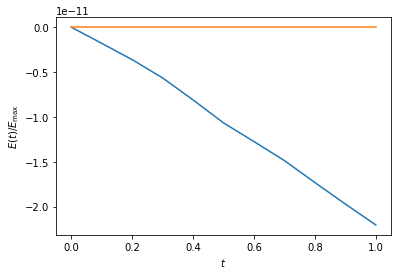

In [16]:
plt.plot(T, E.real/E.real.max() - 1)
plt.plot(T, E.imag/E.real.max())
plt.xlabel(r'$t$')
plt.ylabel(r'$E(t)/E_{\rm max}$')
plt.show()

# Dynamical matrix

In [23]:
def dyn_mat():
    matrix_size = 2*3*np.prod(mesh.shape)
    A = np.zeros((matrix_size, matrix_size), complex)
    for i, y in enumerate(np.eye(matrix_size)):
        A[:,i] = derivative(0, (y + 0j).view(float)).view(complex)
    return A
A = dyn_mat()
e = np.linalg.eigvals(A)    
print(np.abs(e.real).max())
print(np.abs(e.imag).max())

7.11378655635e-14
41.4994456927


In [35]:
k = np.linspace(0, 0.5, 50)
freq = []
for wavenumber in Progress(k):
    mesh_x = Wave(wavenumber)
    mesh_y = Legendre(10, (-Hy/2, Hy/2))
    mesh_z = Legendre(10, (-Hz/2, Hz/2))
    mesh = mesh_x*mesh_y*mesh_z
    A = dyn_mat()
    e = np.linalg.eigvals(A)
    freq.append(e.imag)
freq = np.asarray(freq)

A Jupyter Widget

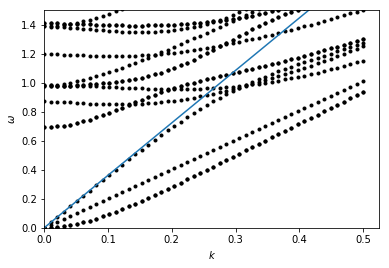

In [42]:
c = np.sqrt(young/rho)
plt.plot(k, freq, 'k.')
plt.plot(k, k*c)
plt.xlim(0, None)
plt.ylim(0, 1.5)
plt.ylabel(r'$\omega$')
plt.xlabel(r'$k$')
plt.show()

In [20]:
e, v = np.linalg.eig(A)
omega = e.imag
sorting = np.argsort(omega)
sorting = sorting[omega[sorting] > 1e-7]
omega = omega[sorting]
frequency = omega/2/np.pi
eigvec = v[:,sorting]

In [21]:
frequency

array([ 0.31707607,  0.31707607,  0.32028061,  0.32092478,  0.341115  ,  0.34400058,  0.34400058,  0.35081883,
        0.36772459,  0.38315433,  0.38315433,  0.40732949,  0.40732949,  0.40779682,  0.41270747,  0.42155371,
        0.42996216,  0.43929048,  0.43929048,  0.46531165,  0.46767564,  0.46767564,  0.4826397 ,  0.48373062,
        0.49404497,  0.49468548,  0.49468548,  0.5087433 ,  0.51612238,  0.52007666,  0.52007666,  0.52891746,
        0.54218648,  0.55365708,  0.55995799,  0.55995799,  0.56772074,  0.57464234,  0.57464234,  0.5763049 ,
        0.5821249 ,  0.58494593,  0.58494593,  0.60961996,  0.60961996,  0.61950179,  0.61950179,  0.62016325,
        0.62034228,  0.6278017 ,  0.63940429,  0.64719734,  0.64719734,  0.64863407,  0.65134084,  0.66257411,
        0.66659307,  0.68302236,  0.68302291,  0.68302291,  0.6832437 ,  0.68517892,  0.69687289,  0.69687289,
        0.69779279,  0.69779279,  0.69895412,  0.70423498,  0.71155102,  0.7257767 ,  0.7257767 ,  0.73999757,
 

In [11]:
frequency[:15]

array([2.41270998e-02, 3.12746494e-02, 3.70974148e-02, 3.70974206e-02, 4.79073214e+02, 5.19039118e+02, 8.06608253e+02,
       9.28394696e+02, 1.31395807e+03, 1.42277100e+03, 2.19115062e+03, 2.51435057e+03, 2.55728318e+03, 2.76632169e+03,
       4.02832867e+03])

In [138]:
# workaround, see https://github.com/enthought/mayavi/issues/503
import sys
stream = sys.stdout 

from mayavi import mlab
mlab.init_notebook('x3d', width=500, height=300)
mlab.options.offscreen = True
from tvtk.api import tvtk
from mayavi.sources.vtk_data_source import VTKDataSource

# workaround, see https://github.com/enthought/mayavi/issues/503
sys.stdout = stream

def mesh(u, scale=1, d=2.5, sub=3):
    (x_min, y_min, z_min), (x_max, y_max, z_max) = u.X1, u.X2
    x = np.linspace(x_min, x_max, sub*round((x_max - x_min)/d) + 1)
    y = np.linspace(y_min, y_max, sub*round((y_max - y_min)/d) + 1)
    z = np.linspace(z_min, z_max, sub*round((z_max - z_min)/d) + 1)
    pts = np.meshgrid(x, y, z, indexing='ij') + scale*u(x, y, z)
    pts = np.moveaxis(pts, 0, -1).real
    
    polys, points, lines = [], [], []
    i0 = 0
    for p in (pts[0], pts[-1], pts[:,0], pts[:,-1], pts[:,:,0], pts[:,:,-1]):
        m, n = p.shape[:2]
        polys += [[i0 + i + j*n, i0 + i + 1 + j*n, 
                   i0 + i + 1 + (j + 1)*n, i0 + i + (j + 1)*n]
                  for i in range(n - 1) for j in range(m - 1)]
        lines += [[i0 + i + j*n for i in range(n)] for j in range(0, m, sub)]
        lines += [[i0 + i + j*n for j in range(m)] for i in range(0, n, sub)]
        points.append(p.reshape(-1, 3))
        i0 += n*m
    points = np.concatenate(points)
    
    mesh = tvtk.PolyData(points=points, lines=lines)
    edges = mlab.pipeline.surface(VTKDataSource(data=mesh))
    mesh = tvtk.PolyData(points=points, polys=polys)
    faces = mlab.pipeline.surface(VTKDataSource(data=mesh))
    return edges, faces

Notebook initialized with x3d backend.


In [143]:
frequency[12]

7764.8031732239124

In [148]:
n = 7
scale = -30 - 30j
y = eigvec[:, n]
u, v = decompress(y)

mlab.clf()
fig = mlab.figure(bgcolor=(1, 1, 1), size=(700, 500))

edges1, faces1 = mesh(u, scale)
edges1.actor.property.color = 0, 0, 0
edges1.actor.property.line_width = 5
edges1.actor.property.render_lines_as_tubes = True
faces1.actor.property.color = 0, 0.5, 1
faces1.actor.property.opacity = 0.8

#mlab.axes(color=(0.5,0.5,0.5))
#fig.scene.parallel_projection = True
mlab.view(10, 105, roll=0, distance=75)
#fig.scene.camera.parallel_scale = 20
#fig.scene.camera.apply_transform(
#fig.scene.camera.

#fig.scene.camera.set_oblique_angles(45, 90)
fig.scene.render_window.multi_samples = 1
fig.scene.render_window.line_smoothing = True

fig

setting roll


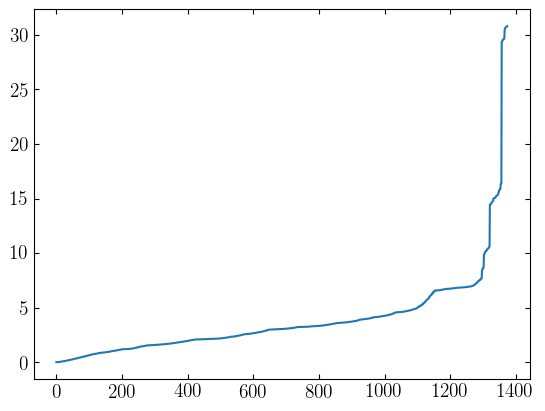

In [55]:
plt.plot(omega)
